# Learning to play 3D Navigation Game using Deep Q-Network

This project is a part of the Udacity Deep Reinforcement Learning Nano-degree requirement. In this report, I described how the Deep Q-Network (DQN) was used to learn a 3D navigation game provided by Unity Environment [here](https://github.com/Unity-Technologies/ml-agents/tree/release_12_docs).

DQN is a Reinforcement Learning (Q-learning) algorithm using Deep Neural Network as a value function approximation (refer to [this paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)). Using DQN, the computer agent was able to achieve a good level of skills to play a 3D navigation game with a sizable number of environmental variables, learning from scratch.

### The Game Environment

The game environment is provided by Unit Technology (please refer to README on how to install). The agent is to navigate through a 3D environment by stepping forward, backward, turn left or turn right and capture as many yellow bananas and avoid purple bananas. The following imports packages and sets up the game environment.

<img src='banana_collector.gif' width="400" height="400">

In [1]:
# setting up the environment in Udacity workspace below
#!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


In [2]:
import numpy as np
import torch
from collections import deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In this project, we have one agent with 4 actions (forward,backward,left and right) and in a simulated 3D environment represented by 37 state variables. 

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### Setting up the DQN

Below I described the setup of the DQN starting with getting the agent, the dimension of the action space and state space.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# getting game parameters
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

I used a four layer linear neural network with ReLU activation function and dropout layer with a probability of 33%. The input is 37 dimensional as mentioned above, which is passed to a 512 dimensional output in the first layer, followed by a second layer with 256 dimensional output and a third layer with 256 dimensional output. The output layer is a 4 dimensional output matching the number of actions such that each dimension represents the value of one of the 4 actions. 

The agent learns from sampling 64 observations randomly experienced before from its memory with a size of 20000. The agent discount the reward in the next timeframe with a discounting factor of 0.995. 

The agent learns how to play by minimizing the MSE errors (between policy value network and Q target) using gradient descent. The optimizing algorithm is Adam with a learning rate of 0.00005, which is chosen to strike a good balance between overshooting and run time. The learning of the policy value network is performed every 4th time during the play and the target network is softly updated with a small degree of 0.001 to the most recently updated policy value network (the purpose of the target network is to avoid the chasing target issue). The agent starts with exploring random actions given a state with a probability of 1 which decays with a rate of 0.995 each episode with a floor of 2.5% probability. Otherwise, the agent will choose the optimal action based on the policy value network.

In [6]:
# setting up the agent
from Agent import QAgent
batch_size = 64
agent = QAgent(state_size,action_size,batch_size)
print(agent.policy_net)

QNet(
  (input_layer): Linear(in_features=37, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=4, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.33)
)


Episode 100	Average Score: 0.34
Episode 200	Average Score: 2.51
Episode 300	Average Score: 6.90
Episode 400	Average Score: 9.45
Episode 500	Average Score: 13.41
Episode 600	Average Score: 12.96
Episode 700	Average Score: 14.21
Episode 800	Average Score: 15.26
Episode 900	Average Score: 13.67
Episode 1000	Average Score: 15.89
Episode 1100	Average Score: 11.85
Episode 1200	Average Score: 15.49
Episode 1300	Average Score: 14.05
Episode 1400	Average Score: 14.73
Episode 1500	Average Score: 15.56
Episode 1600	Average Score: 14.19
Episode 1700	Average Score: 15.79
Episode 1800	Average Score: 14.41
Episode 1900	Average Score: 15.53
Episode 2000	Average Score: 15.28


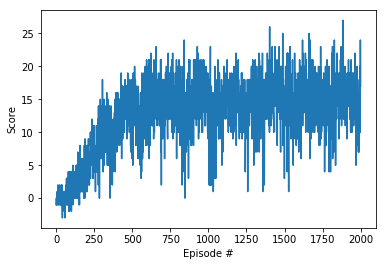

In [7]:
def dqn(agent, n_episodes=2000, max_t=3000, update_every=4, soft_update=True, sync_every=5000, eps_start=1.,
        eps_min=0.025, eps_decay=0.995):
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    step = 0
    eps = eps_start

    for i_episode in range(1, n_episodes + 1):
        score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]

        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action)[brain_name]
            state_next = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.cache(state, action, reward, state_next, done)
            step = (step+1) % update_every
            if step == 0 and len(agent.memory)>batch_size:
                experiences = agent.recall()
                agent.learn(experiences)
                agent.sync_target_net()
            state = state_next
            score += reward
            if done:
                break

        eps = max(eps * eps_decay, eps_min)
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        torch.save(agent.policy_net.state_dict(), 'checkpoint.pth')

    return scores

scores = dqn(agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

env.close()

### Conclusion and Future Improvements

As shown below, the agent was able to achieve a average reward (moving average of 100 episodes) of about 15, after which the performance oscillates quite a bit until episode 2000.

There are a few future improvements that can potentially help with the performance including:  
1. Tuning hyperparameters discussed above to get faster and more stable value network
2. Using the visual screen shot of the environment either alone or in combination with the vector state variables as inputs into the policy network
3. Replacing Q-learning with SARSA or Monte Carlo, which can potentially make the learning faster
4. Using improved version of DQN such as Dueling DQN, Double DQN and Prioritized Experience Replay or combinations as discussed in [this paper](https://arxiv.org/pdf/1710.02298.pdf). 